In [135]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchvision import transforms
import torchvision.models as models
from torch.utils.data import Dataset, DataLoader
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
from PIL import Image
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True
from sklearn.utils import shuffle
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report

In [136]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [137]:
def seed_everything(seed):
    os.environ["PYTHONHASHSEED"] = str(seed)
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

seed_everything(42)

In [138]:
images_path = "/kaggle/input/multimodal-damages-identification-dataset/MultimodalDamageIdentification/Images"
train_csv_path = '/kaggle/input/multimodal-damages-identification-dataset/MultimodalDamageIdentification/train.xlsx'
test_csv_path = '/kaggle/input/multimodal-damages-identification-dataset/MultimodalDamageIdentification/test.xlsx'

In [139]:
train_df = pd.read_excel(train_csv_path)
test_df = pd.read_csv(test_csv_path)

In [140]:
print(len(train_df))
print(len(test_df))

5247
584


In [141]:
trdata = {
    'image': [],
    'label': []
}
combinedf = pd.DataFrame(trdata)

tedata = {
    'image': [],
    'label': []
}
testdf = pd.DataFrame(tedata)

label_map = {
    "non_damage": 0,
    "damaged_infrastructure": 1,
    "damaged_nature": 2,
    "fires": 3,
    "flood": 4,
    "human_damage": 5
}

combinedf['label'] = train_df['label'].map(label_map)
testdf['label'] = test_df['label'].map(label_map)

def replace_string(row):
  return row.replace('.JPG', '.jpg')
combinedf['image'] = train_df['image'].apply(replace_string)
testdf['image'] = test_df['image'].apply(replace_string)


In [142]:
#combinedf = shuffle(combinedf, random_state=42)
traindf=combinedf[:4663]
validdf= combinedf[4663:]

In [143]:
print(len(combinedf))
print(len(traindf))
print(len(validdf))
print(len(testdf))

5247
4663
584
584


In [144]:
# traindf['image_exist'] = traindf['image'].apply(lambda x: os.path.exists(os.path.join(images_path, x)))

In [145]:
# traindf = traindf[traindf['image_exist']]
# traindf = traindf.drop(columns=['image_exist'])

In [146]:
traindf

,image,label
0,buildingfire_2017-02-05_04-06-10.jpg,1
1,isiscrimes_2015-08-04_00-18-33.jpg,5
2,earthquake_2017-11-13_07-23-10.jpg,1
3,ad_2017-11-25_07-56-53.jpg,0
4,hurricanesandy_2017-10-29_22-36-42.jpg,4
...,...,...
4658,ad_2017-11-25_09-56-23.jpg,0
4659,hurricaneirma_2017-11-21_19-52-42.jpg,2
4660,yemencrisis_2016-02-13_02-40-54.jpg,5
4661,building_2017-10-30_17-03-48.jpg,0


In [147]:
validdf

,image,label
4663,treesfalling_2013-12-22_18-58-11.jpg,2
4664,ad_2017-11-25_04-12-10.jpg,0
4665,ad_2017-11-25_10-45-52.jpg,0
4666,naturaldisaster_2017-10-13_07-10-42.jpg,2
4667,wreckedcar_2017-02-12_16-59-16.jpg,1
...,...,...
5242,cars_2017-10-30_17-48-22.jpg,0
5243,buildingfire_2016-12-07_17-48-56.jpg,3
5244,nature_2017-10-30_17-47-15.jpg,0
5245,ad_2017-11-25_11-07-37.jpg,0


In [148]:
testdf

,image,label
0,ad_2017-11-25_10-36-26.jpg,0
1,building_2017-10-30_17-26-34.jpg,0
2,floodwater_2017-09-04_04-46-10.jpg,4
3,accrafloods_2015-06-06_16-59-56.jpg,4
4,buildingfire_2016-10-02_03-07-17.jpg,3
...,...,...
579,floodwater_2017-08-27_23-49-50.jpg,4
580,nature_2017-10-30_17-47-50.jpg,0
581,earthquake_2017-11-13_23-23-28.jpg,1
582,ad_2017-11-25_08-21-38.jpg,0


In [149]:
class_counts = traindf['label'].value_counts()
print(class_counts)

0    2367
1    1114
2     405
4     300
3     274
5     203
Name: label, dtype: int64


In [150]:
class_counts = validdf['label'].value_counts()
print(class_counts)

0    299
1    132
2     54
4     48
3     35
5     16
Name: label, dtype: int64


In [151]:
class_counts = testdf['label'].value_counts()
print(class_counts)

0    291
1    144
2     55
3     37
4     36
5     21
Name: label, dtype: int64


In [152]:
transform_train = transforms.Compose([
    transforms.Resize((150, 150)),
    transforms.Grayscale(num_output_channels=3),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]),
])

transform_test = transforms.Compose([
    transforms.Resize((150, 150)),
    transforms.Grayscale(num_output_channels=3),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]),
])

In [153]:
class CustomDataset(Dataset):
    def __init__(self, dataframe, images_path, transform=None):
        self.dataframe = dataframe
        self.images_path = images_path
        self.transform = transform

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, index):
        img_name = os.path.join(self.images_path, self.dataframe.iloc[index]['image'])
        image = Image.open(img_name)
        label = self.dataframe.iloc[index]['label']

        if self.transform is not None:
            image = self.transform(image)

        return image, label

In [154]:
train_dataset = CustomDataset(traindf, images_path, transform=transform_train)
validation_dataset = CustomDataset(validdf, images_path, transform=transform_test)
test_dataset = CustomDataset(testdf, images_path, transform=transform_test)

In [155]:
class_counts = traindf['label'].value_counts()
class_weights = torch.tensor([1.0 / class_counts[i] for i in range(len(class_counts))])
class_weights = class_weights / class_weights.sum()

In [156]:
class_weights = class_weights.to(device,dtype=torch.float32)

In [157]:
class CustomEfficientNetB3(nn.Module):
    def __init__(self, num_classes):
        super(CustomEfficientNetB3, self).__init__()
        efficientnet = EfficientNet.from_pretrained('efficientnet-b3')
        for param in efficientnet.parameters():
            param.requires_grad = False
        self.efficientnet = efficientnet
        self.fc = nn.Linear(efficientnet._fc.in_features, num_classes)
        
    def forward(self, x):
        x = self.efficientnet.extract_features(x)
        x = nn.functional.adaptive_avg_pool2d(x, (1, 1))
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x

In [158]:
!pip install efficientnet_pytorch
from efficientnet_pytorch import EfficientNet
model = CustomEfficientNetB3(num_classes=6)

Loaded pretrained weights for efficientnet-b3


In [159]:
batch_size = 128
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
valid_loader= DataLoader(validation_dataset, batch_size=batch_size, shuffle=False)

In [160]:
print(len(train_loader))
print(len(test_loader))
print(len(valid_loader))

37
5
5


In [161]:
# for inputs, labels in train_loader:
#     print(inputs.shape, labels.shape)

In [162]:
# from PIL import ImageFile
# ImageFile.LOAD_TRUNCATED_IMAGES = True

# for idx, (images, labels) in enumerate(train_loader):
#     try:
#         if images.shape[1] == 1:
#             print('Image batch dimensions:', idx, images.shape)
#             print('Image label dimensions:', idx, labels.shape)
#     except Exception as e:
#         print(f"Error occurred while processing batch {idx}: {e}")

# print("No")

In [163]:
model.to(device)

CustomEfficientNetB3(
  (efficientnet): EfficientNet(
    (_conv_stem): Conv2dStaticSamePadding(
      3, 40, kernel_size=(3, 3), stride=(2, 2), bias=False
      (static_padding): ZeroPad2d((0, 1, 0, 1))
    )
    (_bn0): BatchNorm2d(40, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
    (_blocks): ModuleList(
      (0): MBConvBlock(
        (_depthwise_conv): Conv2dStaticSamePadding(
          40, 40, kernel_size=(3, 3), stride=[1, 1], groups=40, bias=False
          (static_padding): ZeroPad2d((1, 1, 1, 1))
        )
        (_bn1): BatchNorm2d(40, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
        (_se_reduce): Conv2dStaticSamePadding(
          40, 10, kernel_size=(1, 1), stride=(1, 1)
          (static_padding): Identity()
        )
        (_se_expand): Conv2dStaticSamePadding(
          10, 40, kernel_size=(1, 1), stride=(1, 1)
          (static_padding): Identity()
        )
        (_project_conv): Conv2dS

In [164]:
learning_rate = 0.0001
momentum = 0.9
beta_2 = 0.999
epsilon = 1e-8
weight_decay = 0.0
amsgrad = False

In [165]:
criterion = nn.CrossEntropyLoss()

optimizer = optim.Adam(model.parameters(),
                       lr=learning_rate)

num_iters=10000
num_epochs = num_iters / (len(train_dataset) / batch_size)
num_epochs = int(num_epochs)

patience = 8
best_val_loss = float('inf')
counter = 0

In [166]:
iter= 0
train_loss_history = []
train_acc_history = []
test_loss_history = []
test_acc_history = []

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct_predictions = 0
    total_samples = 0

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()

        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        iter+=1

        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total_samples += labels.size(0)
        correct_predictions += (predicted == labels).sum().item()


    epoch_loss = running_loss / len(train_loader)
    epoch_acc = correct_predictions / total_samples
    train_loss_history.append(epoch_loss)
    train_acc_history.append(epoch_acc)

    print(f"Epoch [{epoch + 1}/{num_epochs}], Train Loss: {epoch_loss:.4f}, Accuracy: {epoch_acc:.4f}")

    model.eval()
    val_loss = 0.0
    val_correct = 0
    val_total = 0
    running_loss = 0.0
    correct_predictions = 0
    total_samples = 0

    with torch.no_grad():
        for inputs, labels in valid_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = model(inputs)
            loss = criterion(outputs, labels)
            running_loss += loss.item()
            val_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total_samples += labels.size(0)
            correct_predictions += (predicted == labels).sum().item()

    epoch_loss = running_loss / len(test_loader)
    epoch_acc = correct_predictions / total_samples
    test_loss_history.append(epoch_loss)
    test_acc_history.append(epoch_acc)

    print(f"Epoch [{epoch + 1}/{num_epochs}], Validation Loss: {epoch_loss:.4f}, Accuracy: {epoch_acc:.4f}")
    
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        counter = 0
        torch.save(model.state_dict(), 'best_model.pt')
        print("Best Model Save")
        model.train()
        
    else:
        counter += 1
        if counter >= patience:
            print(f'Early stopping at epoch {epoch + 1}.')
            break

Epoch [1/274], Train Loss: 1.6824, Accuracy: 0.3350
Epoch [1/274], Validation Loss: 1.6359, Accuracy: 0.3784
Best Model Save
Epoch [2/274], Train Loss: 1.4804, Accuracy: 0.5008
Epoch [2/274], Validation Loss: 1.5247, Accuracy: 0.4777
Best Model Save
Epoch [3/274], Train Loss: 1.3763, Accuracy: 0.5419
Epoch [3/274], Validation Loss: 1.4474, Accuracy: 0.5514
Best Model Save
Epoch [4/274], Train Loss: 1.3139, Accuracy: 0.5578
Epoch [4/274], Validation Loss: 1.3906, Accuracy: 0.5685
Best Model Save
Epoch [5/274], Train Loss: 1.2623, Accuracy: 0.5885
Epoch [5/274], Validation Loss: 1.3427, Accuracy: 0.5771
Best Model Save
Epoch [6/274], Train Loss: 1.2133, Accuracy: 0.5973
Epoch [6/274], Validation Loss: 1.3069, Accuracy: 0.5822
Best Model Save
Epoch [7/274], Train Loss: 1.1883, Accuracy: 0.6123
Epoch [7/274], Validation Loss: 1.2779, Accuracy: 0.5839
Best Model Save
Epoch [8/274], Train Loss: 1.1485, Accuracy: 0.6296
Epoch [8/274], Validation Loss: 1.2508, Accuracy: 0.5856
Best Model Save


KeyboardInterrupt: 

In [ ]:
#iters=0 
#for epoch in range(num_epochs):
#     for i, (im, la) in enumerate(train_loader):

#         im = im.to(device)
#         la = la.to(device)

#         # Clear gradients w.r.t. parameters
#         optimizer.zero_grad()

#         # Forward pass to get output/logits
#         outputs = model(images)

#         # Calculate Loss: softmax --> cross entropy loss
#         loss = criterion(outputs, la)

#         # Getting gradients w.r.t. parameters
#         loss.backward()

#         # Updating parameters
#         optimizer.step()

#         iters += 1

#         if iters % 50 == 0:
#             # Calculate Accuracy
#             correct = 0
#             total = 0
#             # Iterate through test dataset
#             for images, labels in valid_loader:

#                 images = images.to(device)

#                 # Forward pass only to get logits/output
#                 outputs = model(images)

#                 # Get predictions from the maximum value
#                 _, predicted = torch.max(outputs, 1)

#                 # Total number of labels
#                 total += labels.size(0)


#                 # Total correct predictions
#                 if torch.cuda.is_available():
#                     correct += (predicted.cpu() == labels.cpu()).sum()
#                 else:
#                     correct += (predicted == labels).sum()

#             accuracy = 100 * correct.item() / total

#             # Print Loss
#             print('Iteration: {}. Loss: {}. Accuracy: {}'.format(iter, loss.item(), accuracy))

In [167]:
model.load_state_dict(torch.load('best_model.pt'))
print("Best Model Loaded")
model.eval()
predictions = []
true_labels = []

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        outputs = model(inputs)
        _, predicted = torch.max(outputs.data, 1)
        predictions.extend(predicted.cpu().numpy())
        true_labels.extend(labels.cpu().numpy())

Best Model Loaded


In [168]:
accuracy = accuracy_score(true_labels, predictions)
precision = precision_score(true_labels, predictions, average='weighted')
recall = recall_score(true_labels, predictions, average='weighted')
f1 = f1_score(true_labels, predictions, average='weighted')

print("Evaluation Metrics:")
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")

true_labels = np.array(true_labels)
predicted_labels = np.array(predictions)
target_names = ['non_damage', 'damaged_infrastructure', 'damaged_nature', 'fires', 'flood', 'human_damage']
report = classification_report(true_labels, predicted_labels, target_names=target_names)

print("Classification Report:")
print(report)

Evaluation Metrics:
Accuracy: 0.7003
Precision: 0.7021
Recall: 0.7003
F1 Score: 0.6999
Classification Report:
                        precision    recall  f1-score   support

            non_damage       0.79      0.82      0.81       291
damaged_infrastructure       0.69      0.62      0.66       144
        damaged_nature       0.48      0.49      0.49        55
                 fires       0.53      0.65      0.59        37
                 flood       0.69      0.56      0.62        36
          human_damage       0.39      0.43      0.41        21

              accuracy                           0.70       584
             macro avg       0.60      0.59      0.59       584
          weighted avg       0.70      0.70      0.70       584



In [ ]:
print(len(train_acc_history))
print(len(train_loss_history))
print(len(test_acc_history))

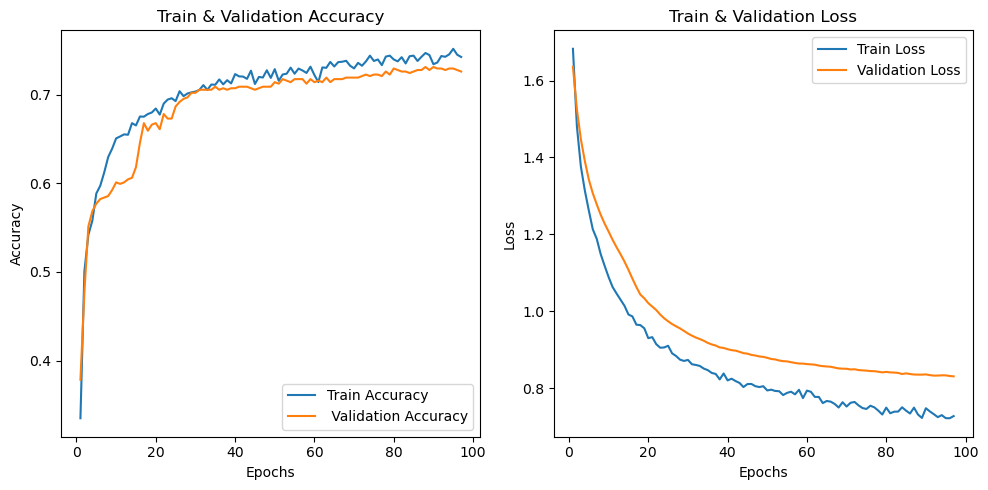

In [169]:
max_epochs = len(train_acc_history)
train_acc_history = train_acc_history[:max_epochs]
test_acc_history = test_acc_history[:max_epochs]

train_loss_history = train_loss_history[:max_epochs]
test_loss_history = test_loss_history[:max_epochs]

plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.plot(range(1, max_epochs+ 1), train_acc_history, label='Train Accuracy')
plt.plot(range(1, max_epochs + 1), test_acc_history, label=' Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Train & Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(range(1, max_epochs + 1), train_loss_history, label='Train Loss')
plt.plot(range(1, max_epochs + 1), test_loss_history, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Train & Validation Loss')

plt.tight_layout()
plt.show()
